# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## Imports

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Data loading

In [11]:
data = pd.read_excel("alldata.xlsx")

#removing any NaN in the dataset
data_without_nan = data.dropna()
data_without_nan = data_without_nan.rename(columns={"parti": "party", "alder": "age", "navn": "name", "storkreds": "constituencies"})

# taking the parties and the age columns
data_filtered = data_without_nan[["party", "age"]]

# we want to filter for people with age greater than 0
data_filtered = data_filtered.loc[data_filtered["age"] > 0]

### Graph of the current data we have

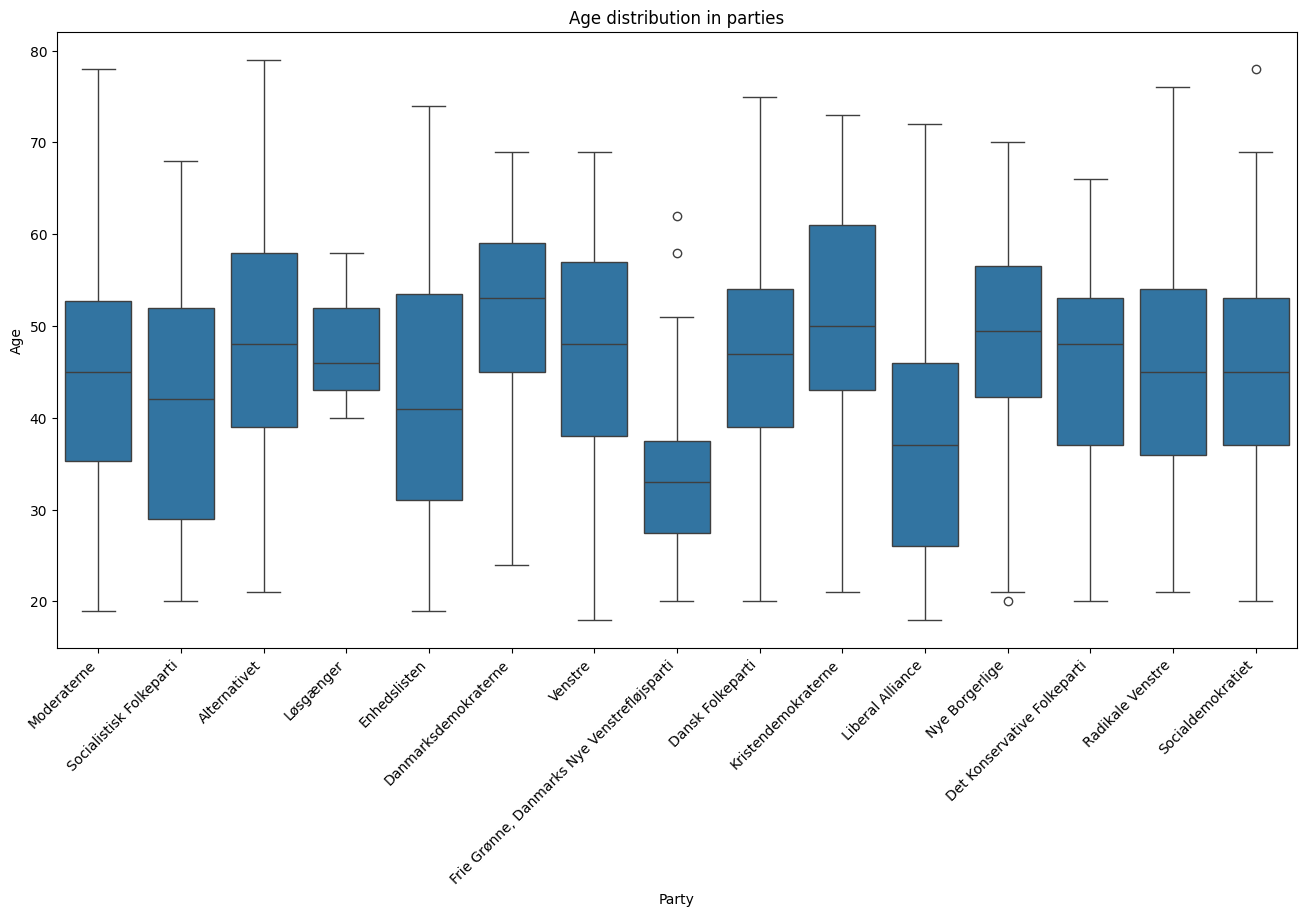

In [12]:
plt.figure(figsize=(16,8))
sea.boxplot(x="party", y="age", data=data_filtered)
plt.xticks(rotation=45, ha="right")
plt.title("Age distribution in parties")
plt.xlabel("Party")
plt.ylabel("Age")
plt.show()


### Filtering data based on the highest proportions of strongly-agree or strongly-disagree

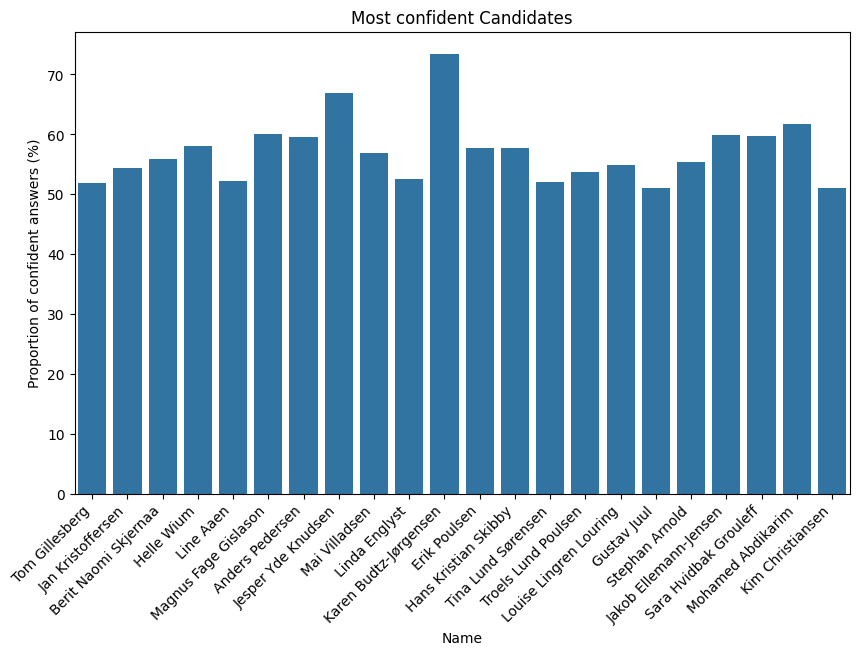

In [13]:
response_columns = ['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', 
                    '6a', '6b', '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', 
                    '11a', '11b', '12a', '12b', '530', '531', '533', '534', '535', 
                    '537', '538', '540', '541', '543', '544', '545', '546', '547', 
                    '548', '550', '551', '552', '553', '555', '556', '557', '559', 
                    '561', '563']
proportions = {}
strongly_agree = 2
strongly_disagree = -2
for col in response_columns:
    total_responses = len(data_without_nan[col])
    strongly_agree_or_disagree_count = ((data_without_nan[col] == strongly_agree) | (data_without_nan[col] == strongly_disagree)).sum()
    proportion = strongly_agree_or_disagree_count / total_responses
    proportions[col] = proportion

agree_disagree_proportions = pd.DataFrame(proportions.items(), columns=['column', 'proportion'])
agree_disagree_proportions["name"] = data_without_nan["name"]

#showing only the
_figure_data = agree_disagree_proportions[agree_disagree_proportions["proportion"] >= 0.5]
#converting to percentages
_figure_data.loc[:, "proportion"] = agree_disagree_proportions["proportion"] * 100

plt.figure(figsize=(10, 6))
sea.barplot(x='name', y='proportion', data=_figure_data)
plt.xticks(rotation=45, ha='right')
plt.title('Most confident Candidates')
plt.xlabel('Name')
plt.ylabel('Proportion of confident answers (%)')
plt.show()

### Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
#### Intra-Party:

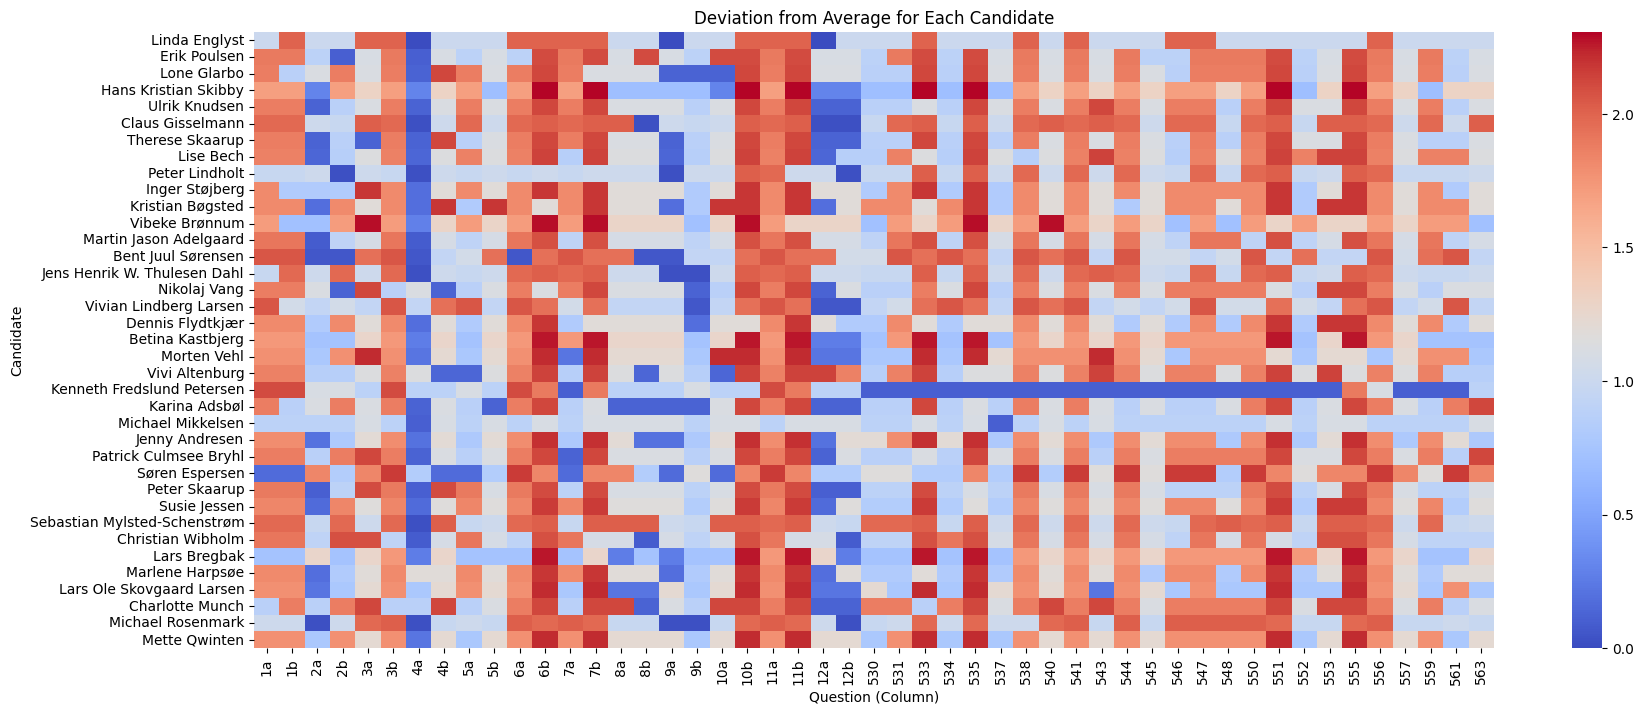

In [14]:
party = data_without_nan[data_without_nan["party"] == "Danmarksdemokraterne"]

# Calculate average for each question
averages = party[response_columns].mean(axis=1)

# Calculate deviation from average for each candidate
deviations = party[response_columns].sub(averages, axis=0)

# Take the absolute value of the deviations
deviations = deviations.abs()

# Add candidate names to the DataFrame
deviations['name'] = party['name']

# Set 'Name' as the index of the DataFrame
deviations.set_index('name', inplace=True)
# Visualize the data using a bar plot
plt.figure(figsize=(20, 8))
sea.heatmap(deviations, annot=False, cmap='coolwarm')
plt.title('Deviation from Average for Each Candidate')
plt.ylabel('Candidate')
plt.xlabel('Question (Column)')
plt.show()

In the heatmap above, we can observe the responses of the "Danmarksdemokraterne" members to the questions and see how much their answers differ from the party's average.
Legend:
* red means that the answer is very different from the average
* blue means that the answer is close, or even the average.

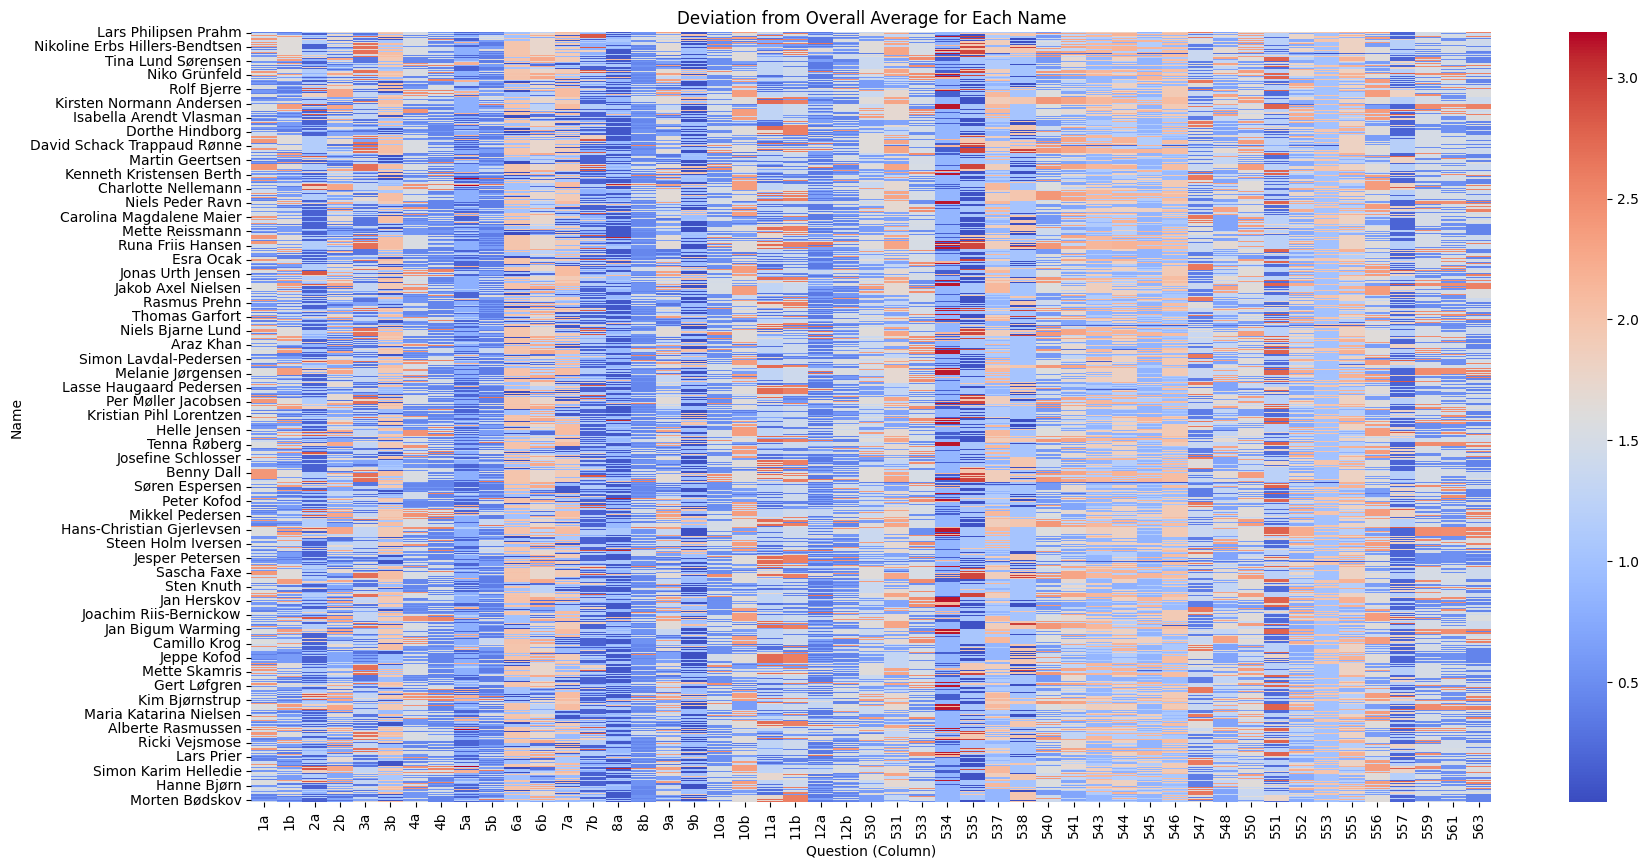

In [15]:
overall_averages = data_without_nan[response_columns].mean()
overall_deviations = data_without_nan[response_columns].sub(overall_averages)
overall_deviations = overall_deviations.abs()
overall_deviations["name"] = data_without_nan["name"]
overall_deviations.set_index("name", inplace=True)

# Visualize the data using a heatmap
plt.figure(figsize=(20, 10))
sea.heatmap(overall_deviations, annot=False, cmap='coolwarm')
plt.title('Deviation from Overall Average for Each Name')
plt.ylabel('Name')
plt.xlabel('Question (Column)')
plt.show()

### Inter-party

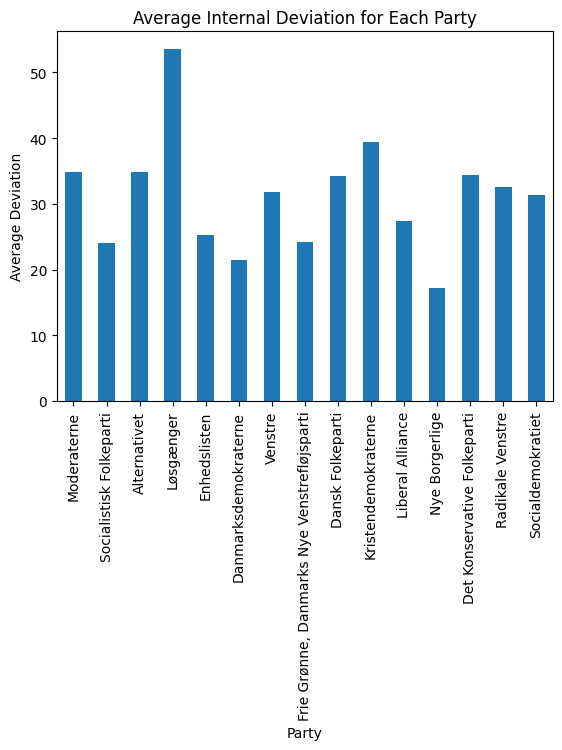

In [16]:
# Get a list of unique parties
parties = data_without_nan['party'].unique()

# Initialize an empty DataFrame to store the average deviations for each party
party_deviations = pd.DataFrame()

# Loop through each party
for party_name in parties:
    # Filter data for the current party
    party = data_without_nan[data_without_nan['party'] == party_name]
    
    # Ensure the data is numeric
    party.loc[:, response_columns] = party[response_columns].apply(pd.to_numeric, errors='coerce')
    
    # Calculate average for each question
    averages = party[response_columns].mean()
    
    # Calculate deviation from average for each candidate
    deviations = party[response_columns].sub(averages)
    
    # Take the absolute value of the deviations
    deviations = deviations.abs()
    
    # Sum the deviations and divide by the number of people in the party (Finding the average deviation)
    average_deviation = deviations.sum().sum() / len(party)
    
    # Add to the party_deviations DataFrame (that has a Party and Average Deviation features)
    deviation_df = pd.DataFrame([{'party': party_name, 'average_deviation': average_deviation}])
    party_deviations = pd.concat([party_deviations, deviation_df], ignore_index=True)

# Set 'Party' as the index of the DataFrame
party_deviations.set_index('party', inplace=True)

# Visualize the data using a bar plot
party_deviations.plot(kind='bar', legend=False)
plt.title('Average Internal Deviation for Each Party')
plt.ylabel('Average Deviation')
plt.xlabel('Party')
plt.show()

It might seem that Løsgænger (independent candidates) has the highest average of deviation or has the most internal disagreements but they don't belong to any party. (since they are independent candidates)
But Kristendemokraterne is a party, thus making it the party with the most internal disagreements 

# Machine learning time :)

In [17]:
# initialize data (translated to eng)
ml_data = data_without_nan[[
                    "party",
                    "age",
                    "530",
                    "531",
                    "533",
                    "534",
                    "535",
                    "537",
                    "538",
                    "540",
                    "541",
                    "543",
                    "544",
                    "545",
                    "546",
                    "547",
                    "548",
                    "550",
                    "551",
                    "552",
                    "553",
                    "555",
                    "556",
                    "557",
                    "559",
                    "561",
                     "1a",
                     "1b",
                     "2a",
                     "2b",
                     "3a",
                     "3b",
                     "4a",
                     "4b",
                     "5a",
                     "5b",
                     "6a",
                     "6b",
                     "7a",
                     "7b",
                     "8a",
                     "8b",
                     "9a",
                     "9b",
                     "10a",
                     "10b",
                     "11a",
                     "11b",
                     "12a",
                     "12b",]]

# Dropping party for the algorithm to predict which party the candidate should be assigned to.
# x - data without target y - is a target of prediction
x = ml_data.drop('party', axis=1)
y = ml_data['party']

# Standartizing data for algorithms
scaler = StandardScaler()  
x = scaler.fit_transform(x)
seed = 666 # for shit and giggles
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=seed)

# Desicion Tree
# Using default values for DecisionTreeClassifier as it fits our data
decision_tree = DecisionTreeClassifier(random_state=seed)

# Random Forest
# By default we will have 100 trees, we will use square root of total number of features.
random_forest = RandomForestClassifier(random_state=seed)

# Gradient Boosted Tree
gradient_boosting = GradientBoostingClassifier(random_state=seed)

# K-nearest neighbours
# By default uses:
# 5 neighbours (n_neigbours)
# p - euclidian distance
knn = KNeighborsClassifier()

# Gaussian kernell
# By default uses:
# C = 1 - regularization parameter
# kernel = rbf - radial basis function (very good when the data points are centric)
# gamma = scale - the amount of fitting we want to do for our training data
svc = SVC()

# Logistic Regression
# By default uses:
# penalty - l2
# c - 1 regularization strenght
# solver = lbfgs - for data with multiple answers
logistic_regression = LogisticRegression(solver="lbfgs")

# Train classifiers
decision_tree.fit(x_train, y_train)
random_forest.fit(x_train, y_train)
gradient_boosting.fit(x_train, y_train)
knn.fit(x_train, y_train)
svc.fit(x_train, y_train)
logistic_regression.fit(x_train, y_train)

# Make predictions
dt_predictions = decision_tree.predict(x_test)
rf_predictions = random_forest.predict(x_test)
gb_predictions = gradient_boosting.predict(x_test)
knn_predictions = knn.predict(x_test)
svc_predictions = svc.predict(x_test)
logistic_predictions = logistic_regression.predict(x_test)

# Evaluate models
print("Decision Tree Accuracy: ", accuracy_score(y_test, dt_predictions))
print("Random Forest Accuracy: ", accuracy_score(y_test, rf_predictions))
print("Gradient Boosting Accuracy: ", accuracy_score(y_test, gb_predictions))
print("KNN Accuracy: ", accuracy_score(y_test, knn_predictions))
print("SVC Accuracy: ", accuracy_score(y_test, svc_predictions))
print("Logicstic Regression Accuracy: ", accuracy_score(y_test, logistic_predictions))

# Potential misalignments
asymmetrical_df = pd.DataFrame({
    'Actual': y_test,
    'DecisionTree': dt_predictions,
    'RandomForest': rf_predictions,
    'GradientBoosting': gb_predictions,
    'KNN': knn_predictions,
    'SVC': svc_predictions,
    'LogisticRegression': logistic_predictions
})

asymmetrical_df = asymmetrical_df.assign(Candidate=data_without_nan["name"])

# Prints the ones which are misalignmented
asymmetrical_df[asymmetrical_df['DecisionTree'] != asymmetrical_df['Actual']]
asymmetrical_df[asymmetrical_df['RandomForest'] != asymmetrical_df['Actual']]
asymmetrical_df[asymmetrical_df['GradientBoosting'] != asymmetrical_df['Actual']]
asymmetrical_df[asymmetrical_df['KNN'] != asymmetrical_df['Actual']]
asymmetrical_df[asymmetrical_df['SVC'] != asymmetrical_df['Actual']]
asymmetrical_df[asymmetrical_df['LogisticRegression'] != asymmetrical_df['Actual']]


Decision Tree Accuracy:  0.7235023041474654
Random Forest Accuracy:  0.9124423963133641
Gradient Boosting Accuracy:  0.8663594470046083
KNN Accuracy:  0.8341013824884793
SVC Accuracy:  0.9216589861751152
Logicstic Regression Accuracy:  0.9078341013824884


,Actual,DecisionTree,RandomForest,GradientBoosting,KNN,SVC,LogisticRegression,Candidate
387,Det Konservative Folkeparti,Venstre,Det Konservative Folkeparti,Det Konservative Folkeparti,Venstre,Det Konservative Folkeparti,Venstre,Anne Fiber
567,Det Konservative Folkeparti,Kristendemokraterne,Kristendemokraterne,Venstre,Det Konservative Folkeparti,Venstre,Venstre,Dorthe Schmittroth
557,Nye Borgerlige,Nye Borgerlige,Nye Borgerlige,Nye Borgerlige,Liberal Alliance,Liberal Alliance,Liberal Alliance,Thomas Vedsted
250,Venstre,Kristendemokraterne,Liberal Alliance,Løsgænger,Moderaterne,Det Konservative Folkeparti,Det Konservative Folkeparti,Phillip Sperling
154,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Radikale Venstre,Alternativet,Alternativet,Enhedslisten,Alternativet,Alternativet,Sazan Garmiyani
224,Socialdemokratiet,Radikale Venstre,Radikale Venstre,Venstre,Radikale Venstre,Radikale Venstre,Radikale Venstre,Mette Reissmann
674,Nye Borgerlige,Dansk Folkeparti,Dansk Folkeparti,Dansk Folkeparti,Dansk Folkeparti,Dansk Folkeparti,Dansk Folkeparti,Claus Bedemann
349,Venstre,Det Konservative Folkeparti,Det Konservative Folkeparti,Det Konservative Folkeparti,Det Konservative Folkeparti,Det Konservative Folkeparti,Det Konservative Folkeparti,Bo Sandberg
697,Radikale Venstre,Radikale Venstre,Radikale Venstre,Radikale Venstre,Radikale Venstre,Radikale Venstre,Socialistisk Folkeparti,Hikmet Altun
89,Det Konservative Folkeparti,Det Konservative Folkeparti,Kristendemokraterne,Kristendemokraterne,Det Konservative Folkeparti,Det Konservative Folkeparti,Kristendemokraterne,Per Urban Olsen


In [18]:
#Looking for candidates that should be in a different party - based on voting
#Only models
df = pd.DataFrame()

#Add a column for the count of the most common prediction
df['Prediction count'] = asymmetrical_df.apply(lambda row: row.value_counts().max(), axis=1)

#Add a column for the most common prediction
df['Most Common'] = asymmetrical_df.mode(axis=1)[0]

#Adding candidate names
df = df.assign(Candidate=asymmetrical_df["Candidate"])

#Adding the party our candidates belong to
df = df.assign(Actual=asymmetrical_df["Actual"])

df['Wrong Party'] = (df['Most Common'] != df['Actual']) & (df['Prediction count'] > 3)

#Create a new DataFrame with the required columns
wrong_party_df = df[df['Wrong Party']][['Candidate', 'Actual', 'Most Common', 'Prediction count']]

#Rename the columns
wrong_party_df.columns = ['Candidate', 'Actual Party', 'Predicted Party', 'Prediction count']

#Sorting from the highest count of model guesses
wrong_party_df = wrong_party_df.sort_values(by='Prediction count', ascending=False)

#Print the DataFrame
wrong_party_df.head(15)

,Candidate,Actual Party,Predicted Party,Prediction count
349,Bo Sandberg,Venstre,Det Konservative Folkeparti,6
674,Claus Bedemann,Nye Borgerlige,Dansk Folkeparti,6
129,Emil Samaras,Enhedslisten,Socialistisk Folkeparti,6
42,Ali Khatib,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet,6
224,Mette Reissmann,Socialdemokratiet,Radikale Venstre,5
827,Jørgen Mathow-Juhl,Liberal Alliance,Det Konservative Folkeparti,5
491,Carsten Sohl,Alternativet,Enhedslisten,5
154,Sazan Garmiyani,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet,4
721,Christoffer Emil Jexen,Enhedslisten,Socialistisk Folkeparti,4
433,Rishi Balachandran,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Enhedslisten,4


The best accurate algorithm we had was SVC with the 0.92 score. When it comes to candidates who seemed to be in the wrong party we have Bo Sandeberg (and the others with 6 wrong predictions) that he should be part of the Det Konservative Folkeparti and not part of Venstre.